In [1]:
!pip install peft
!pip install flash_attn
!pip install bitsandbytes
!pip install tiktoken
!pip install verovio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 3.7 MB/s eta 0:00:00ta 0:00:01
  Using cached flash_attn-2.6.3.tar.gz (2.6 MB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [22 lines of output]
      fatal: not a git repository (or any of the parent directories): .git
      
      
      torch.__version__  = 2.3.0
      
      
      /tmp/pip-install-6fe3xwd5/flash-attn_e595c6334dd2464b856b64d2ec8100b7/setup.py:95: UserWarning: flash_attn was requested, but nvcc was not found.  Are you sure your environment has nvcc available?  If you're installing within a container from https://hub.docker.com/r/pytorch/pytorch, only images whose names contain 'devel' will provide nvcc.
        warnings.warn(
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/tmp/pip-i

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
sys.path.append("/kaggle/input/amazon-challenge/student_resource 3/src")

In [3]:
import torch
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
from constants import entity_unit_map, allowed_units
from transformers import AutoConfig, AutoModel, AutoTokenizer
from transformers import AutoTokenizer, AutoModelForCausalLM
from accelerate import init_empty_weights, infer_auto_device_map, load_checkpoint_in_model, dispatch_model

In [4]:
inference_img_path = "/kaggle/input/train-csv-files/test_images_data/home/taruntejaneurips23/student_resource_3/student_resource/dataset/test_images"
inference_data_path = "/kaggle/input/images-path-and-text/test_path_text.csv"

In [5]:
inference_data = pd.read_csv(inference_data_path)

In [6]:
inference_data.head()

,index,image_link,group_id,entity_name,image_path,image_id,image_text
0,0,https://m.media-amazon.com/images/I/110EibNycl...,156839,height,./dataset/test_images/110EibNyclL.jpg,110EibNyclL,['1 1 1 ha ']
1,1,https://m.media-amazon.com/images/I/11TU2clswz...,792578,width,./dataset/test_images/11TU2clswzL.jpg,11TU2clswzL,"['size width length one size 42cm/1654"" 200cm/..."
2,2,https://m.media-amazon.com/images/I/11TU2clswz...,792578,height,./dataset/test_images/11TU2clswzL.jpg,11TU2clswzL,"['size width length one size 42cm/1654"" 200cm/..."
3,3,https://m.media-amazon.com/images/I/11TU2clswz...,792578,depth,./dataset/test_images/11TU2clswzL.jpg,11TU2clswzL,"['size width length one size 42cm/1654"" 200cm/..."
4,4,https://m.media-amazon.com/images/I/11gHj8dhhr...,792578,depth,./dataset/test_images/11gHj8dhhrL.jpg,11gHj8dhhrL,"['azis width length 1 1050cm/413"" 90cm/3543"" ']"


In [7]:
MODEL_PATH = 'openbmb/MiniCPM-V-2_6-int4'
OCR_MODEL = 'ucaslcl/GOT-OCR2_0'
POST_MODEL = "/kaggle/input/gemma-2/transformers/gemma-2-2b/2/"

In [8]:
model = AutoModel.from_pretrained(MODEL_PATH, low_cpu_mem_usage=True, trust_remote_code=True)
model.eval()

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH, trust_remote_code=True)

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
# ocr_model = AutoModel.from_pretrained(OCR_MODEL, trust_remote_code=True, low_cpu_mem_usage=True, device_map='cuda', use_safetensors=True, pad_token_id=tokenizer.eos_token_id)
# ocr_model.eval()

# ocr_tokenizer = AutoTokenizer.from_pretrained(OCR_MODEL, trust_remote_code=True)

In [10]:
# post_model = AutoModelForCausalLM.from_pretrained(
#     POST_MODEL,
#     device_map="cuda:1",
# )
# post_model.eval()
# post_tokenizer = AutoTokenizer.from_pretrained(POST_MODEL)

In [11]:
def generate_prompt(image_path, entity_name):
#     ocr_text = ocr_model.chat(ocr_tokenizer, image_path, ocr_type='ocr', ocr_box='')
    image = Image.open(image_path).convert('RGB')
    prompt = f"""You are given:
1. **Image**: Contains measurements or product specifications.
2. **Entity Name**: A specific entity like `width`, `item_weight`, `voltage`, etc.
3. **Unit Map**: A set of valid units for each entity, as shown below:

**Unit Map**:  
- `width`, `depth`, `height`: {{centimetre, foot, inch, metre, millimetre, yard}}  
- `item_weight`, `maximum_weight_recommendation`: {{gram, kilogram, ounce, pound, ton}}  
- `voltage`: {{kilovolt, millivolt, volt}}  
- `wattage`: {{kilowatt, watt}}  
- `item_volume`: {{litre, millilitre, gallon, quart, pint}}

### Task:
1. Extract the value for the given entity (`{entity_name}`) from image.
2. Return only the value and unit in the output, without any explanation or additional information.
3. If necessary, convert the unit to one from the Unit Map.

### Task Input:
- **Entity Name**: "{entity_name}"

### Output:
Return the entity value and its correct unit, with no explanations.
"""
    return image, prompt, ""

In [12]:
entity_map = '''Entity Unit Map:
- item_weight: ['gram', 'kilogram', 'microgram', 'milligram', 'ounce', 'pound', 'ton']
- width, depth, height: ['centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard']
- maximum_weight_recommendation: ['gram', 'kilogram', 'microgram', 'milligram', 'ounce', 'pound', 'ton']
- voltage: ['kilovolt', 'millivolt', 'volt']
- wattage: ['kilowatt', 'watt']
- item_volume: ['centilitre', 'cubic foot', 'cubic inch', 'cup', 'decilitre', 'fluid ounce', 'gallon', 'imperial gallon', 'litre', 'microlitre', 'millilitre', 'pint', 'quart']
'''

In [13]:
os.listdir(inference_img_path)[0]

'918LQehcw0L.jpg'

In [14]:
inference_img_path

'/kaggle/input/train-csv-files/test_images_data/home/taruntejaneurips23/student_resource_3/student_resource/dataset/test_images'

In [15]:
os.path.basename(inference_data["image_path"][0])

'110EibNyclL.jpg'

In [16]:
os.path.isfile(os.path.join(inference_img_path, os.path.basename(inference_data["image_path"][0])))

True

In [17]:
sample = inference_data.iloc[0, :]

In [18]:
# img_path = os.path.join(inference_img_path, os.path.basename(sample["image_path"]))
# res = ocr_model.chat(ocr_tokenizer, img_path, ocr_type='ocr')
# res

In [19]:
sample = inference_data.iloc[0, :]
img_path = os.path.join(inference_img_path, os.path.basename(sample["image_path"]))
entity = sample["entity_name"]
image, prompt, ocr_text = generate_prompt(img_path, entity)

height


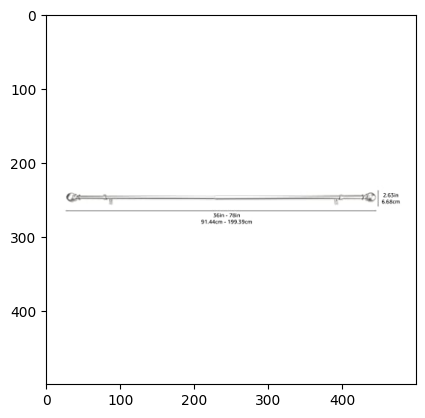

In [20]:
print(entity)
plt.imshow(image)

In [21]:
# msgs = [{'role': 'user', 'content': prompt}]

# res = model.chat(
#     image=image,
#     msgs=msgs,
#     context=None,
#     tokenizer=tokenizer,
#     sampling=False
# )
# print(res)

In [ ]:
results = []
entities = []
batch = 8
count = 0
for idx in tqdm(range(0, len(inference_data), batch), total=len(inference_data)//batch):
    msgs = []
    samples = inference_data.iloc[idx: idx+batch, :]
    for i, sample in samples.iterrows():
        img_path = os.path.join(inference_img_path, os.path.basename(sample["image_path"]))
        entity = sample["entity_name"]
        image, prompt, ocr_text = generate_prompt(img_path, entity)
        msgs.append({'role': 'user', 'image':image, 'content': prompt})
    res = model.chat(
        image=None,
        msgs=msgs,
        context=None,
        tokenizer=tokenizer,
        sampling=False
    )
    results.extend(res)
    entities.extend(entity)
    count += 1
    if count == 5:
        break

  0%|          | 0/11967 [00:00<?, ?it/s]

## post process outputs using entity maps like convert cm to centimeters. Use entity names to find the relevant units and convert the units by matching.
## create submission files from results list

In [ ]:
results, entities

In [ ]:
# def generate_post_prompt(result, entity):
#     prompt = f"""You are given the measures of an entity. Modify measure using the correct unit from the provided entity-unit map when needed.
# Example:
# Measure: 2cm
# Entity: item_weight
# Output: 2 centimeter

# Example:
# Measure: 100.0 w
# Entity: wattage
# Output: 100.0 watt

# Example:
# Measure: 10.5gallon
# Entity: item_volume
# Output: 10.5 gallon

# Entity Unit Map:
# - item_weight: ['gram', 'kilogram', 'microgram', 'milligram', 'ounce', 'pound', 'ton']
# - width, depth, height: ['centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard']
# - maximum_weight_recommendation: ['gram', 'kilogram', 'microgram', 'milligram', 'ounce', 'pound', 'ton']
# - voltage: ['kilovolt', 'millivolt', 'volt']
# - wattage: ['kilowatt', 'watt']
# - item_volume: ['centilitre', 'cubic foot', 'cubic inch', 'cup', 'decilitre', 'fluid ounce', 'gallon', 'imperial gallon', 'litre', 'microlitre', 'millilitre', 'pint', 'quart']

# Input:
# Measure: {result}
# Entity: {entity}
# Output: """
#     return prompt

In [ ]:
# def generate_answer(prompts, max_length=10):
#     input_ids = post_tokenizer(prompts, return_tensors="pt")
#     input_ids = input_ids["input_ids"].to("cuda:1")
#     outputs = post_model.generate(input_ids, max_new_tokens=max_length)
#     outputs = outputs[:, input_ids.shape[1]:]
#     return post_tokenizer.batch_decode(outputs, skip_special_tokens=True, clean_up_tokenization_spaces=True)

In [ ]:
# post_results = []
# for res, ent in tqdm(zip(results, entities), total=len(results)):
#     prompt = generate_post_prompt(res, ent)
#     post_results.append(generate_answer(prompt))

In [ ]:
# tokenizer = AutoTokenizer.from_pretrained("/kaggle/input/gemma-2/transformers/gemma-2-9b/2/")
# model = AutoModelForCausalLM.from_pretrained(
#     "/kaggle/input/gemma-2/transformers/gemma-2-9b/2/",
#     device_map="auto",
#     torch_dtype=torch.bfloat16
# )

In [ ]:
# input_text = "Write me a poem about Machine Learning."
# input_ids = tokenizer(input_text, return_tensors="pt")

# outputs = model.generate(**input_ids, max_length=200)
# print(tokenizer.decode(outputs[0]))

In [ ]:
# input_texts = ["Write me a poem about Machine Learning.",
#                "Write me a poem about Deep Learning.",
#                "Write me a poem about Reinforcement Learning."
#               ]
# input_ids = tokenizer(input_texts, return_tensors="pt")

# outputs = model.generate(**input_ids)
# print(tokenizer.batch_decode(outputs))

In [ ]:
# inference_data["image_text"][3][2:-2], inference_data["entity_name"][3]

In [ ]:
# generate_prompt(inference_data["image_text"][2][2:-2], inference_data["entity_name"][2])

In [ ]:
# generate_answer([generate_prompt(inference_data["image_text"][17][2:-2], inference_data["entity_name"][17])])